# Stochastic-Spectral Methods for Uncertainty Propagation 
# Polynomial Chaos Expansion (PCE)
 **Saleh Rezaeiravesh and Philipp Schlatter** <br/> 
 saleh.rezaeiravesh@manchester.ac.uk and pschlatt@mech.kth.se <br/> 
 Modelling & Simulation, Department of Mechanical, Aerospace and Civil Engineering (MACE), The University of Manchester, UK <br/> 
 SimEx/FLOW, Engineering Mechanics, KTH Royal Institute of Technology, Sweden
___

In [1]:
import sys
import numpy as np
import math as mt
import matplotlib.pyplot as plt
sys.path.append('./modules/')
import grafix
import rosenbrock

### Learning Objectives
* Getting familiar with the non-intrusive PCE (concept, formulation, implementation),
* Becoming able to Apply PCE to different model functions,
* Making comparison between the performance of PCE and random sampling methods for uncertainty propagation.

## Introduction
PCE is widely used in UQ applications for construction of a surrogate of the model response over the parameter space as well as uncertainty propagation or UQ forward problem. For the latter, PCEs can be used both intrusively  and non-intrusively. In the latter, a surrogate is constructed based on the parameters samples and evaluation of the model which is treated as a blackbox. 

Consider, the model output or response $y$ is related via a model function $f$ to the fixed inputs $\chi$ and uncertain parameter $q$:

$$
\begin{equation}
y=f(\chi,q)
\end{equation}\label{model}\tag{1}
$$

For simplicity, we assume the dimensionality of $q$ to be one, although an extension of the PCE to multi-dimensional parameter space is given below. 

Using the PCE, the model function can be expanded as, 

$$
\begin{equation}
\tilde{f}(\chi,q) = \sum_{k=0}^K \hat{f}_k (\chi) \psi_k(q)  \,,
\end{equation}\label{pce1d}\tag{2}
$$

where the $\tilde{}$ shows an approximate representation of the actual $f(\chi,q)$ which is either known or unknown (blakbox). 
Clearly, the stochasticity of $f(\chi,q)$ is fully represented by the basis functions $\psi_k(q)$, and given a training dataset, associated coefficients $\hat{f}_k (\chi)$ are to be determined. 

Once the PCE is constructed, it can be used for estimating the stochastic moments of the model function. In particular, 

$$
\begin{eqnarray}
\mathbb{E}[f(q)] &=& \hat{f}_0(\chi) \\
\mathbb{V}[f(q)] &=& \sum_{k=1}^K \hat{f}^2_k(\chi) \gamma_k \\
\end{eqnarray}
$$

## Basis functions

Assume a random variable (RV) $\xi\in \Gamma$. This RV has a distribution with associated PDF $\rho(\xi)$. 
Then for the PCE, we are interested in finding basis functions $\{\psi_k\}_{k=1}^K$ which satisfy the following conditions:
    
1. Orthogonality with respect to $\rho(\xi)$: This can be written in form a weighted inner-product:

$$
\begin{equation}
   \langle \psi_i (\xi)\psi_j (\xi) \rangle_\rho :=\int_\Gamma  \psi_i (\xi)\psi_j (\xi)\rho(\xi) d\xi 
   =\gamma_i \delta_{ij}
\end{equation}   
$$        
where $\delta_{ij}$ is the Kronecker Delta, and

$$
\begin{equation}
\gamma_i = \langle \psi_{i}(\xi) \psi_{i}(\xi) \rangle_\rho
\end{equation}
$$

2. The first basis satisfies,
$$
\begin{equation}
\mathbb{E}(\psi_0(\xi)) = \int_\Gamma \psi_0(\xi) \rho(\xi) d\xi = 1
\end{equation}
$$

### Choosing the bases
The use of the expansion ([2](#mjx-eqn-pce1d)) goes back to the work by [Weiner, 1938](https://www.jstor.org/stable/2371268) who used the Hermite polynomials to express the stochasticity in random variables with Gaussian distribution. 

[Xiu and Karniadakis, 2003](http://www.sci.utah.edu/~dxiu/Papers/XiuK_JCP03.pdf) extended the approach to various distributions of a random variable $\xi$. They showed, for a given distribution optimal polynomial basis functions can be chosen to maximize the convergence of the PCE expansion ([2](#mjx-eqn-pce1d)). This resulted in the generalized PCE (gPCE).

These basis functions are accessible in `numpy` through class `polynomial`. Here in this notebook, we consider only Legendre and Hermite polynomials for the uniform and Gaussian random variables, respectively. 

In [2]:
#gPCE basis taken from UQit
def gPCE_basis(n_,xi_,distType_):
    """
    Evaluates gPCE polynomial basis of order `n_` at `xi_` points taken from the mapped 
    space :math:`\Gamma`.
    The standard polynomials are chosen based on the gPCE rules.        
    Args:
      `n_`: int
         Order of the basis
      `xi_`: 1D numpy array of size m
         Points taken from the mapped space
      `distType_`: string
         Distribution type of the random parameter (based on the gPCE rule)
       
    Returns:
      `psi`: 1D numpy array of size m
         Values of the gPCE basis at `xi_`     
    """
    if distType_=='Unif':
       psi=np.polynomial.legendre.legval(xi_,[0]*n_+[1])
    elif distType_=='Norm':
       psi=np.polynomial.hermite_e.hermeval(xi_,[0]*n_+[1])
    return psi

Plot Legendre polynomial bases up to order `n`:

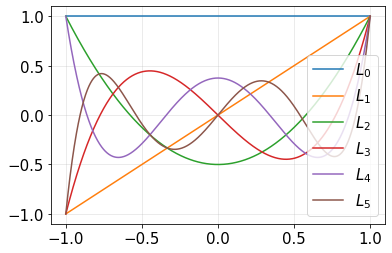

In [3]:
n=6
xi=np.linspace(-1,1,1000)
for n_ in range(n):
    L=gPCE_basis(n_,xi,'Unif')
    plt.plot(xi,L,label=r'$L_'+str(n_)+'$')
plt.legend(loc='best')        
plt.grid()

In [4]:
#Check orthogonality of the basis functions
n_=10   #polynomial order
L1=gPCE_basis(n_,xi,'Unif')
L2=gPCE_basis(n_+2,xi,'Unif')
inProd=np.trapz(y=L1*L2, x=xi)
print(inProd*0.5)

4.4401080857837255e-05


Plot Hermite polynomial bases up to order `n`:

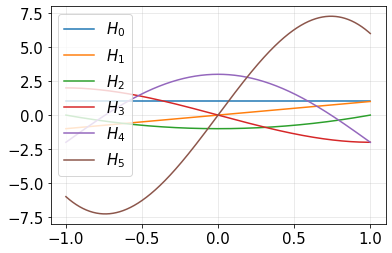

In [5]:
n=6
m_=0
s_=0.1
xi=np.linspace(m_-10*s_,m_+10*s_,1000)
for n_ in range(n):
    L=gPCE_basis(n_,xi,'Norm')
    plt.plot(xi,L,label=r'$H_'+str(n_)+'$')
plt.legend(loc='best')  
plt.grid()

### Estimating the coefficients of PCE
Consider a set of training samples $\{q^{(i)}\}_{i=1}^n$ are chosen at which the model function $y=f(q)$ is evaluated. Using ???

Function `gqPtsWts()` returns the quadrature nodes and weights based on the gauss-quadrature rule given the number of quadrature points and standard distribution of the random variable (only uniform and Gaussian distributions are implemented here).

In [6]:
#Gauss-Quadrature rule, taken from UQit
def gqPtsWts(n_,distType_):
    """
    Gauss quadrature nodes and weights associated to distribution type `type_`
    based on the gPCE rule.
    Args:
       `n_`: int, 
           Order of the gPCE polynomial.
       `type_`: string, 
           Distribution of the random variable according to the gPCE rule
    Returns:
       `quads`: 1D numpy array of size `n_` 
        Gauss quadrature nodes
        `weights`: 1D numpy array of size `n_` 
        Gauss quadrature weights
    """
    if distType_=='Unif':
       x_=np.polynomial.legendre.leggauss(n_)
    elif distType_=='Norm':
       x_=np.polynomial.hermite_e.hermegauss(n_)
    quads=x_[0]
    weights=x_[1]    
    #Multipliers for the Gauss-quadrature integration rule, when using the weights provided by numpy.    
    if distType_=='Unif':
       fac_=0.5
    elif distType_=='Norm':
       fac_=1./mt.sqrt(2*mt.pi)
    return quads,weights,fac_

Function `gqRule()` uses `gqPtsWts()` and works for one or more uncertain parameters. It also maps $\xi\in\Gamma$ to $q\in\mathbb{Q}$ for Uniform and Gaussian distributions.

In [7]:
def gqRule(n,distType,qInfo):
    """
    Weight and xi\in\Gamma based on the GQ rule    
    Args:
        `n`: list of GQ points for each parameter
        `distType`: list of distribution type of the parameters, 'Unif', 'Norm'
        `qInfo`: List of length 2 (optional)       
            `qInfo`=[qMin,qMax] if distType=='Unif'
            `qInfo`=[mean,sdev] if distType=='Norm'
    """
    p=len(distType)   #dimenionality of the parameters
    
    xi=[]
    w=[]
    integFac=[]
    qGQ=[]    
    for i in range(p):
        xi_,w_,fac_=gqPtsWts(n[i],distType[i])    
        xi.append(xi_)
        w.append(w_)
        integFac.append(fac_)
        if distType[i]=='Unif':
           qGQ.append((0.5*(xi_+1.0)*(qInfo[i][1]-qInfo[i][0])+qInfo[i][0]))
        elif distType[i]=='Norm':
           qGQ.append(qInfo[i][0]+qInfo[i][1]*xi_)
    return xi,w,integFac,qGQ   

## Example: Model with one parameter
Consider the following algebraic equation,
$$
y=f(q)=q+0.7 \sin(5 q) + 3 \cos(q) \,,
$$
which depends on parameter $q$. Here we assume, $q\sim \mathcal{N}(1,0.3^2)$ and use PCE to construct mean and variance of $f(q)$. Moreover, we will look at the surrogate for $f(q)$ which is constructed by PCE.

First, we define the function as,

In [8]:
y1d= lambda q: q+0.7*np.sin(5*q)+3*np.cos(q)

The following small python function shows an implementation of PCE:

In [9]:
def gPCE1D_cnstrct(nGQ,xi,w,integFac,fGQ,distType):
    """
    Construct PCE for one parameter    
    
    `fGQ`: numpy array of size n
    distType='Unif', 'Norm'
    """    
    K=nGQ
    
    fCoef=np.zeros(K)   #PCE Coefficients
    pce_inn=np.zeros(K) #PCE inner-product
    
    for k in range(nGQ): 
        psi_k=gPCE_basis(k,xi,distType)        
        
        sum1=np.sum(fGQ*psi_k[0]*w[0])
        sum2= np.sum(psi_k[0]**2.*w[0])
        
        fCoef[k]=sum1/sum2
        pce_inn[k]=sum2*integFac[0]
        
    return fCoef,pce_inn

First, we create `n` Gauss-Hermite samples for $q$ at which $f(q)$ is evaluated. This leads to the training data to construct the PCE.
Note that we first draw samples for $\xi\sim\mathcal{N}(0,1)$ and then $q=m+s\xi$ where $q\sim\mathcal{N}(m,s^2)$.

In [10]:
n=6             #number of Gauss-Hermite samples
qInfo_=[1,0.3]  #mean and standard-deviation of q

#Create training samples
xi,w,integFac,qGQ=gqRule([n],distType=['Norm'],qInfo=[qInfo_])
yTrain=y1d(qGQ[0])

Call `gPCE1D_cnstrct()` to construct the PCE. The exported coefficients as well as the inner-product of the PCE bases are used to estimate mean and variance of $f(q)$.

In [11]:
#Construct the PCE
fCoef1,pce_inn1=gPCE1D_cnstrct(n,xi,w,integFac,yTrain,'Norm')

#Estimate mean and variance of f(q)
m1=fCoef1[0]
s1=np.sum(fCoef1[1:]**2*pce_inn1[1:])
print('E[f(q)]=%g and V[f(q)]=%g' %(m1,s1))

E[f(q)]=2.33174 and V[f(q)]=0.2143


**Discussion** 
* Compare these estimated values for different values of `n` with what can be obtained from the Monte Carlo sampling method and perturbation method.

Next, we can plot the true function along with the Gauss-Hermite training samples and the approcimate function obtained from PCE (surrogate).

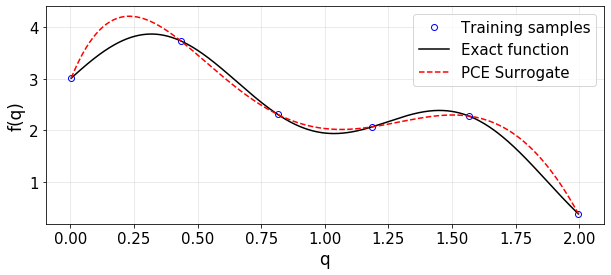

In [12]:
plt.figure(figsize=(10,4))

plt.plot(qGQ[0],yTrain,'ob',label='Training samples')

nTest=1000   #number of equispaced samples of q
qTest=np.linspace(np.min(qGQ[0]),np.max(qGQ[0]),nTest)
plt.plot(qTest,y1d(qTest),'-k',label='Exact function')

#PCE as a surrogate
xiTest=(qTest-qInfo_[0])/qInfo_[1]

psi1d=np.zeros((n,nTest))
for k in range(n): 
    psi1d[k,:]=gPCE_basis(k,xiTest,'Norm')     
yRec1=np.sum(fCoef1*psi1d.T,axis=1)
      
plt.plot(qTest,yRec1,'--r',label='PCE Surrogate')

plt.xlabel('q')
plt.ylabel('f(q)')
plt.legend()
plt.grid()

**Disscusion** 
* Study how the approximate function by PCE converges to the exact function as the number of training samples `n` changes. 
* Do we really need an accurate approximation of $f(q)$ to guarantee accurate estimates for the mean and variance of $f(q)$?

## Application to Multi-parameter Model Functions

Consider $\mathbf{q}\in \mathbb{Q}\subset \mathbb{R}^p$, where $\mathbb{Q}$ is a tensor-product of $\mathbb{Q}_i$ associated to the $i$-th parameter. Assume the parameters $\mathbf{q}=[q_1,q_2,\ldots,q_p]$ are mutually independent and the distribution of $q_i$ is denoted by $\rho_{Q_i}(q_i)$. 

The PCE expansion for the $p$ parameters is written as,

$$
\begin{equation}
\tilde{f}(\chi,\mathbf{q}) = \sum_{k=0}^K \hat{f}_k(\chi) \Psi_k(\mathbf{\xi})
\end{equation}
$$

where $\Psi_k(\mathbf{\xi}) = \psi_{k_1}(\xi_1)\psi_{k_2}(\xi_2)\cdots\psi_{k_p}(\xi_p)$, $k$ is unique re-index corresponding to the multi-index $\mathbf{k}=\{k_1,k_2,\cdots,k_p\}$ is a multi-index.
As in the one-parameter case, $\xi_i\in\Gamma_i$ is the mapped value of $q_i\in\mathbb{Q}_i$. 

The orthogonality condition with respect to $\rho(\mathbf{\xi})$ reads as, 

$$
\begin{equation}
\langle \Psi_{\mathbf{k}}(\mathbf{\xi}) \Psi_{\mathbf{m}}(\mathbf{\xi})\rangle_\rho = \gamma_\mathbf{k} \delta_{\mathbf{k}\mathbf{m}}
\end{equation}
$$

To constuct the PCE for $p$ parameters, the following have to be done:
1. Based on the distribution of the $i$-th parameter, the associated basis functions are chosen. 
2. A truncation scheme for the PCE expansion is chosen, based on which $K$ and multi-index $\mathbf{k}$ are determined.
3. Given a set of training data, the unknown coefficients $\hat{f}_k$ are computed. 


## Example: The Rosenbrock Function (two parameters)

We revisit the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) which is an algebraic model with two parameters $q_1$ and $q_2$:
$$
\begin{equation}
f(q_1,q_2) = a(q_2-q_1^2)^2 + (b-q_1)^2  \,,
\end{equation}
$$
where $a$ and $b$ are two fixed constants with default values $a=100$ and $b=1$.

The following function evaluates the Rosenbrock function for given values of $a$, $b$, $q_1$, and $q_2$.

In [13]:
#Rosenbrock function
Rsbrk = lambda a, b, q1, q2 : a*(q2-q1**2)**2+(b-q1)**2

Assume $q_1$ and $q_2$ are uniformly distributed as $q_1\sim\mathcal{U}[q_{1_L},q_{1_R}]$ and $q_2\sim\mathcal{U}[q_{2_L},q_{2_R}]$. Also, assume these eparameters are mutually independent. 

We are going to use PCE with different constructions to estimate $\mathbb{E}(f(\mathbf{q}))$ and $\mathbb{V}(f(\mathbf{q}))$. 

### Tensor-product truncation with projection method
First, we use Gauss-Legendre rules to create $n_1$ and $n_2 $samples for $q_1$ and $q_2$, respectively. Therefore there are $n=n_1\times n_2$ samples over the 2D parameter space. Using the tensor-product truncation leads to $K=n_1\times n_2 -1$. The projection method is used to compute the PCE coeffcients from the training data.
Given the coeffcients, the stochstic moments of $f(\chi,\mathbf{q})$ can be estimated. 

First, we provide the required information for consturcting the PCE.

In [14]:
n=[4,5]   #number of GQ points for the parameters
a=100     #Constants in Rosenbrock function
b=1
q_bound=[[-2,2],   #q1 bound
         [-2,2]]   #q2 bound

Using `gqRule()` defined above, the quuadrature points $\mathbf{\xi}$ and associated $\mathbf{q}$ and weights $w$ as well as values of $\gamma_k$ are determined. 

In [15]:
xi,w,integFac,qGQ=gqRule(n,['Unif','Unif'],q_bound)   

The Rosenbrock function is evaluated at a grid of sampling points.

In [16]:
qGQ_grid=np.vstack(np.meshgrid(qGQ[0],qGQ[1])).reshape(2,-1).T
y_ex=Rsbrk(a,b,qGQ_grid[:,0],qGQ_grid[:,1])

The following function applies PCE for tensor-product truncation scheme for two parameters with the inputs being the training data and quadrature points and weights to apply projection method for computing the unknown coeffcients in PCE. Note that the code is not written in an efficient way, for calrity and educational purposes. 

In [17]:
def gPCE2D_TP_cnstrct(nGQ,xi,w,integFac,fGQ,distType):
    """
    Construct a 2D PCE based on tensor product
    (from my library)
    `fGQ`: numpy array of ndim=number of parameters    
    distType='Unif', 'Norm'
    """
    K=nGQ[0]*nGQ[1]  #upper bound of sum in PCE (assuming full tensor product)

    #find the coefficients in the expansion
    fCoef=np.zeros(K)   #PCE Coefficients
    pce_inn=np.zeros(K) #PCE inner-product
    sum2=[]
    for k2 in range(nGQ[1]):  #k-th coeff in PCE - param2
        psi_k2=gPCE_basis(k2,xi[1],distType[1])
        for k1 in range(nGQ[0]):  #k-th coeff in PCE - param1
            psi_k1=gPCE_basis(k1,xi[0],distType[0])
            sum1=0.0
            sum2_=0.0
            k=k2*nGQ[0]+k1
            for j2 in range(nGQ[1]):
                for j1 in range(nGQ[0]):
                    j=j2*nGQ[0]+j1                    
                    sum1 += fGQ[j]*(psi_k1[j1]*psi_k2[j2]*w[0][j1]*w[1][j2])
                    sum2_+=        (psi_k1[j1]*psi_k2[j2])**2.*w[0][j1]*w[1][j2]
            fCoef[k]=sum1/sum2_
            pce_inn[k]=sum2_*integFac[0]*integFac[1]
    return fCoef,pce_inn

Calling the function `gPCE2D_TP_cnstrct()` returns the $\hat{f}_{k}$ and $\gamma_{k}$ for $k=1,2,\cdots,K$. 

In [18]:
fPCE_prj_coefs,pce_inn_prj=gPCE2D_TP_cnstrct(n,xi,w,integFac,y_ex,distType=['Unif','Unif'])

Now, we can estimate the stochastic moments of the Rosenbrock function with the assumed distributions for $q_1$ and $q_2$. 

In [19]:
#mean
fPCE_prj_mean=fPCE_prj_coefs[0]

#variance
fPCE_prj_var=np.sum(fPCE_prj_coefs[1:]**2*pce_inn_prj[1:])

print('PCE-TP-Projection -----------')
print('E[f(q)] = ',fPCE_prj_mean)
print('V[f(q)] = ',fPCE_prj_var)

PCE-TP-Projection -----------
E[f(q)] =  455.66666666666646
V[f(q)] =  353054.55600907


We can use the constructed PCE as a surrogate to evaluate the Rosenbrock functions over the whole range of variation of $q_1$ and $q_2$ and comapre the plot with what could be obtained from direct evaluation of the Rosenbrock functions. 

### Convergence of the stochastic mean and variance of the Rosenbrock function

The exact moments of the Rosenbrock function for iid uniform distribution of $q_1$ and $q_2$ can be calculated by `rosenbrock.exactMoments()`.

In [21]:
mExct,vExct=rosenbrock.exactMoments(a,b,q_bound)

Therefore, we can compare the error between stochastic mean and variance of $f(\mathbf{q})$ estimated by the PCE (tensor-product truncation) and the exact values. Repeating this for various number of quadrature sample points, we can study the reduction of the errors. 

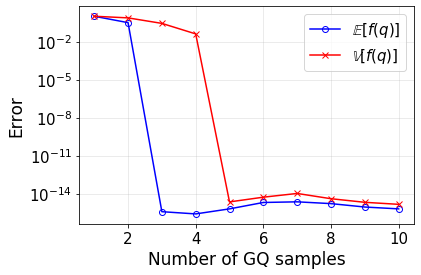

In [22]:
nList=[1,2,3,4,5,6,7,8,9,10]  #number of GQ points for q1 and q2
m_err=[]
v_err=[]
for n_ in nList: 
    #create training data
    xi,w,integFac,qGQ=gqRule([n_,n_],['Unif','Unif'],q_bound)    
    qGQ_grid=np.vstack(np.meshgrid(qGQ[0],qGQ[1])).reshape(2,-1).T
    y_=Rsbrk(a,b,qGQ_grid[:,0],qGQ_grid[:,1])  
    
    #Estimate E[f(q)] and V[f(q)] using PCE method
    fPCE_prj_coefs,pce_inn_prj=gPCE2D_TP_cnstrct([n_,n_],xi,w,integFac,y_,distType=['Unif','Unif'])
    fPCE_prj_var=np.sum(fPCE_prj_coefs[1:]**2*pce_inn_prj[1:])

    m_err.append(abs(fPCE_prj_coefs[0]-mExct)/mExct)
    v_err.append(abs(fPCE_prj_var-vExct)/vExct)

#plot
plt.semilogy(nList,m_err,'-ob',label=r'$\mathbb{E}[f(q)]$')
plt.semilogy(nList,v_err,'-xr',label=r'$\mathbb{V}[f(q)]$')
plt.xlabel('Number of GQ samples')
plt.ylabel('Error')
plt.legend()
plt.grid()

**Discussion**
* Compare the above plot with that obained by using the Monte Carlo sampling method for the Rosenbrock function with the same random parameters. what can we say about the rate of convergence of estimated stochastic moments of the model function with number of samples in two methods?
* Task: Plot the response surface of the 

### Total-order truncation with regression method
Now, we would like to use the regression method for estimating the PCE coefficients. 
Here, we provide an option to create training samples from the parameters to be according to the Gauss-quadrature method or random sampling. 
Moreover, we use the total-order truncation scheme according to which the multi-index set is, 

$$
\begin{equation}\label{eq:pceTO}
\Lambda^{\rm{TOM}}_\mathbf{k} = \{\mathbf{k}\in\mathbb{Z}^p_\geq : \sum_{i=1}^p k_i\leq L \} \,.
\end{equation}
$$

Given a training dataset $\{q^{(i)},f(q^{{i}})\}_{i=1}^n$, the regression method solves a linear system to obtain the PCE coefficients $\hat{\mathbf{f}}=\{\hat{f}_1,\hat{f}_2,\cdots,\hat{f}_K\}$.

First we set the options for creating the training data and constructing the PCE.

In [23]:
n=[6,7]  #number of samples from each of the parameters
LMax=6  #maximum sum of multi-indices in the TO scheme
trainType='random'  #type of training samples 'random', 'GQ'

The trainig data are created.

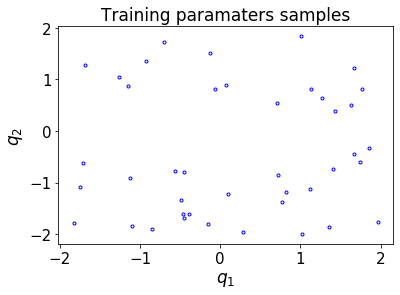

In [24]:
#Create training samples
if trainType=='GQ':
   xi_,w,integFac,qGQ=gqRule(n,['Unif','Unif'],q_bound)   
   xi=np.vstack(np.meshgrid(xi_[0],xi_[1])).reshape(2,-1).T
   q_grid=np.vstack(np.meshgrid(qGQ[0],qGQ[1])).reshape(2,-1).T
elif trainType=='random':
   xi=np.random.uniform(low=-1,high=1,size=(n[0]*n[1],2))  #uniform random from [-1,1]    
   q_grid=np.zeros_like(xi)
   for i in range(2):        
       q_grid[:,i]=(0.5*(xi[:,i]+1.0)*(q_bound[i][1]-q_bound[i][0])+q_bound[i][0])

#plot    
plt.plot(q_grid[:,0],q_grid[:,1],'ob',ms=3)
plt.xlabel(r'$q_1$')
plt.ylabel(r'$q_2$')
plt.title('Training paramaters samples')

#Evaluate the Rosenbrock function at the training samples  
yTO=Rsbrk(a,b,q_grid[:,0],q_grid[:,1])   

The following function `gPCE2D_TO_cnstrct` constructs the PCE for two paramaters with uniform or Gaussian distributions, using total-order truncation scheme and regression method to compute the PCE coefficients.

In [25]:
def gPCE2D_TO_cnstrct(n,LMax,xi,f,distType):
    """
    Construct a 2D PCE based on  Total-Order truncation scheme
    (from my library)
    `fGQ`: numpy array of ndim=number of parameters    
    distType='Unif', 'Norm'
    """    
    p=xi.shape[-1]
    nData=len(f)
    
    K=int(mt.factorial(LMax+p)/(mt.factorial(LMax)*mt.factorial(p))) #upper bound of the PCE sum
    print('n=%d, K=%d' %(nData,K))
    Nmax=(LMax+1)**p
    kOrderList=[LMax+1]*p    
    
    #compute inner-prodoct of the gPCE basis by quadrature rule
    xiAux=[]
    wAux=[]
    fac=[]
    for i in range(p):
        xi_,w_,integFac_=gqPtsWts(n[i],distType[i])
        xiAux.append(xi_)
        wAux.append(w_)
        fac.append(integFac_)    

    #find the coefficients in the expansion
    kSet=[]    #index set for the constructed PCE
    kGlob=np.arange(Nmax)   #Global index
    kLoc=kGlob.reshape(kOrderList,order='F')  #Local index
    for i in range(Nmax):
        k_=np.where(kLoc==kGlob[i])
        kSet_=[]
        for j in range(p): kSet_.append(k_[j][0])
        if (sum(kSet_)<=LMax):
           kSet.append(kSet_)       
    
    # Regression method to compute PCE coefficients
    A=np.zeros((nData,K))    
    if A.shape[1]<=A.shape[0]:
       pce_inn=np.zeros(K)
       for k in range(K):         
           psi_k_=gPCE_basis(kSet[k][0],xiAux[0],distType[0])            
           sum2_=np.sum(psi_k_**2*wAux[0])*fac[0]
           aij_=gPCE_basis(kSet[k][0],xi[:,0],distType[0])
           for i in range(1,p):
               aij_*=gPCE_basis(kSet[k][i],xi[:,i],distType[i])
               psi_k_=gPCE_basis(kSet[k][i],xiAux[i],distType[i])
               sum2_*=np.sum(psi_k_**2*wAux[i])*fac[i]
           A[:,k]=aij_
           pce_inn[k]=sum2_
    else:
       raise ValueError("Reduce LMax so that K<nData is satisfied. Otherwise, compressed sensing method is needed.") 
            
    #Find the PCE coefficients by Regression
    M=np.dot(A.T,A)   
    R=np.dot(A.T,f)
    fCoef=np.linalg.solve(M,R) 
        
    return fCoef,pce_inn

Call the function to obtain the PCE coefficients $\hat{f}_k$ and $\gamma_k$ for $k=1,2,\cdots,K$.

In [26]:
fPCE_reg_coefs,pce_inn_reg=gPCE2D_TO_cnstrct(n,LMax,xi,yTO,distType=['Unif','Unif'])

n=42, K=28


In [27]:
#mean
fPCE_reg_mean=fPCE_reg_coefs[0]

#variance
fPCE_reg_var=np.sum(fPCE_reg_coefs[1:]**2*pce_inn_reg[1:])

print('PCE-TO-Regression -----------')
print('E[f(q)] = ',fPCE_reg_mean)
print('V[f(q)] = ',fPCE_reg_var)

PCE-TO-Regression -----------
E[f(q)] =  455.66666666666674
V[f(q)] =  367915.32698412513


**Discussion**
* Compare the estimated moments with associated exact values as well as the moments estimated by the tensor product truncation (above). Can you make any conclusion?